# Hipotesis:

    En problemas de clasificación de sentimiento, entrenar una red para realizar POS-tagging como tarea auxiliar contribuye a mejorar el desempeño en la tarea principal.

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
nltk.download('averaged_perceptron_tagger')
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk import pos_tag
from nltk.tokenize import word_tokenize,sent_tokenize
import re
nltk.download('treebank')
nltk.download('brown')
nltk.download('conll2000')
nltk.download('universal_tagset')
from nltk.corpus import brown
from nltk.corpus import treebank
from nltk.corpus import conll2000
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, LSTM, Bidirectional, GRU, BatchNormalization,Embedding
from keras.layers import Dense, Conv1D, MaxPooling1D
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.preprocessing import LabelEncoder

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Rod\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package treebank to
[nltk_data]     C:\Users\Rod\AppData\Roaming\nltk_data...
[nltk_data]   Package treebank is already up-to-date!
[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\Rod\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package conll2000 to
[nltk_data]     C:\Users\Rod\AppData\Roaming\nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\Rod\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


# ¿Qué es Pos tag?

Pos tag = part of speech tag, significa etiquetar las palabras de un texto dependiendo si son adjetivos, verbos, pronombres, etc.

# Generacion de dataset

Con ayuda de la libreria NLTK se genero un dataset en base a los corpus (cuerpos de texto general) que contiene sus respectivas etiquetas.

In [ ]:
treebank_corpus = treebank.tagged_sents(tagset='universal')
brown_corpus = brown.tagged_sents(tagset='universal')
conll_corpus = conll2000.tagged_sents(tagset='universal')
tagged_sentences = treebank_corpus + brown_corpus + conll_corpus

In [ ]:
X = [] 
Y = [] 

for sentence in tagged_sentences:
    X_sentence = []
    Y_sentence = []
    for entity in sentence:         
        X_sentence.append(entity[0]) 
        Y_sentence.append(entity[1])  
        
    X.append(X_sentence)
    Y.append(Y_sentence)

# Tokenización de las palabras

A cada palabra se le asigna un número id para representarla.

In [ ]:
word_tokenizer = Tokenizer()                    
word_tokenizer.fit_on_texts(X)                   
X_encoded = word_tokenizer.texts_to_sequences(X) 

In [ ]:
tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(Y)
Y_encoded = tag_tokenizer.texts_to_sequences(Y)

# Padding de textos

Limitamos el largo a 100 palabras por oración y aquellas con menor cantidad a 100 se le agregan ceros para que queden del mismo tamaño

In [ ]:
MAX_SEQ_LENGTH = 100
X_padded = pad_sequences(X_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")
Y_padded = pad_sequences(Y_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")

In [ ]:
X, Y = X_padded, Y_padded

# Encodeo de tags (requerido por el modelo)

In [ ]:
Y = to_categorical(Y)

In [ ]:
EMBEDDING_SIZE  = 100 
VOCABULARY_SIZE = len(word_tokenizer.word_index) + 1

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=4)

In [ ]:
NUM_CLASSES = Y.shape[2]

In [ ]:
postag_model = Sequential()
# Embedding para tener una mejor representación del texto a procesar
postag_model.add(Embedding(input_dim     = VOCABULARY_SIZE,
                         output_dim    = EMBEDDING_SIZE,          
                         input_length  = MAX_SEQ_LENGTH, 
                         mask_zero=True
                        ))
postag_model.add(LSTM(64, return_sequences=True))
postag_model.add((Dense(NUM_CLASSES, activation='softmax')))
postag_model.compile(loss      =  'categorical_crossentropy',
                   optimizer =  'adam',
                   metrics   =  ['accuracy'])
postag_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          5944900   
                                                                 
 lstm (LSTM)                 (None, 100, 64)           42240     
                                                                 
 dense (Dense)               (None, 100, 13)           845       
                                                                 
Total params: 5,987,985
Trainable params: 5,987,985
Non-trainable params: 0
_________________________________________________________________


In [ ]:
postag_model.fit(X_train, Y_train, batch_size=128, epochs=5, validation_data=(X_test, Y_test))

Epoch 1/5
452/452 [==============================] - 170s 364ms/step - loss: 0.1533 - accuracy: 0.7837 - val_loss: 0.0350 - val_accuracy: 0.9468
Epoch 2/5
452/452 [==============================] - 195s 433ms/step - loss: 0.0262 - accuracy: 0.9580 - val_loss: 0.0274 - val_accuracy: 0.9544
Epoch 3/5
452/452 [==============================] - 207s 457ms/step - loss: 0.0193 - accuracy: 0.9673 - val_loss: 0.0259 - val_accuracy: 0.9565
Epoch 4/5
452/452 [==============================] - 210s 465ms/step - loss: 0.0165 - accuracy: 0.9714 - val_loss: 0.0256 - val_accuracy: 0.9572
Epoch 5/5
452/452 [==============================] - 214s 473ms/step - loss: 0.0146 - accuracy: 0.9749 - val_loss: 0.0259 - val_accuracy: 0.9575


In [ ]:
def cleaner(text):
    text=text.lower()
    for c in "\n":
        text = text.replace(c," ")
    abrev = re.compile(r"'\b\w+\b")
    text = abrev.sub(r'',text).strip()
    
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'#\S+', '', text)
    text = re.sub(r'@\S+', '', text)
    
    tag = re.compile(r'<.*?>')
    text = tag.sub(r' ',text).strip()
    for c in "!#$%&\°'()*+,-./:;<=>?@[\\]^_{|}~`ø÷´¨\"":
        text = text.replace(c,"")
        
    #text = " ".join([lemmatizer.lemmatize(word) for word in text.split()])                          
    text = " ".join([word for word in str(text).split() if word not in STOPWORDS])
    return text

# Amazon review sentiment

Reviews sobre alimentos entregados por amazon donode los usuarios le entregan una puntuacion de 1 a 5
https://www.kaggle.com/code/laowingkin/amazon-fine-food-review-sentiment-analysis/data

In [ ]:
df1 = pd.read_csv('data1/data1.csv')

In [ ]:
df1 = df1[['Score', 'Text']]

In [ ]:
df1.shape

(568454, 2)

In [ ]:
df1.Score.unique()

array([5, 1, 4, 2, 3], dtype=int64)

# Balanceo de clases
Especificamente la clase '5' que era considerablemente mas abundante que las demas

In [ ]:
# Sub sampleamos score == 5 dado que esta altamente desbalanceado
score_5 = df1[df1.Score==5]
df1 = df1[~df1.index.isin(score_5.index)]
score_5 = score_5.sample(frac=.25)
df1 = pd.concat([df1, score_5], axis=0)

In [ ]:
# Limpiando el texto
df1.Text = df1.Text.apply(lambda x : cleaner(x))

In [ ]:
X_amz = df1.Text
Y_amz = df1.Score

In [ ]:
#Y_cat = to_categorical(Y_amz)

# Distribucion de clases (balanceada)

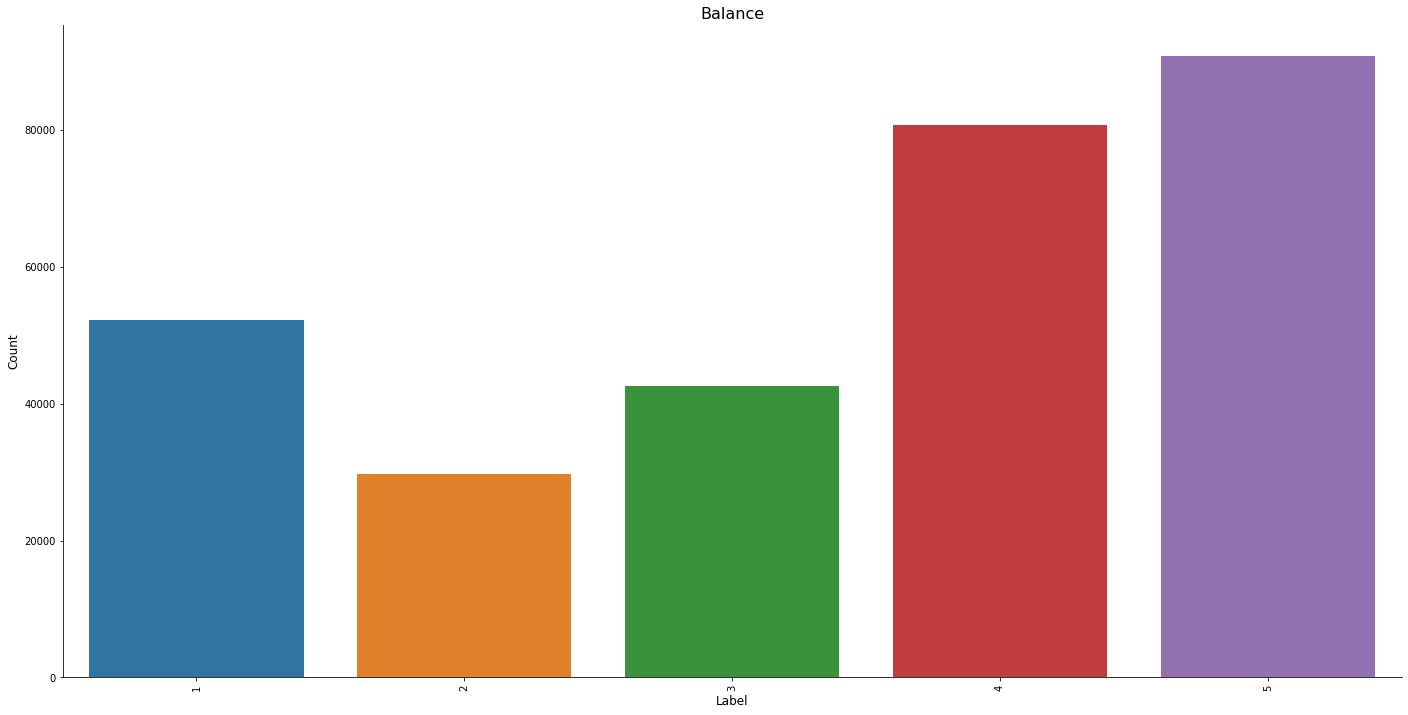

In [ ]:
plt.figure(figsize=(24,12))
plt.title('Balance', size=16)
sns.countplot(x=Y_amz)
plt.ylabel('Count', size=12)
plt.xlabel('Label', size=12)
plt.xticks(rotation=90)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [ ]:
#Encoding label
encoder = OneHotEncoder()
Y_cat=encoder.fit_transform(Y_amz.values.reshape(-1,1)).toarray()

In [ ]:
Y_cat

array([[1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]])

In [ ]:
amz_X_train, amz_X_test, amz_y_train, amz_y_test = train_test_split(X_amz, Y_cat, test_size=0.2, random_state=42)

# Tokenizando las reviews (con el vocabulario del modelo de pos tag)

In [ ]:
amz_X_train_tk = word_tokenizer.texts_to_sequences(amz_X_train)
amz_X_test_tk = word_tokenizer.texts_to_sequences(amz_X_test)

amz_vocab_len = len(word_tokenizer.word_index) + 1 

In [ ]:
VOCABULARY_SIZE

59449

In [ ]:
amz_X_train_tk = pad_sequences(amz_X_train_tk, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")
amz_X_test_tk = pad_sequences(amz_X_test_tk, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")

# Modelo sin uso de pos tag
Se entrega unicamente las reviews tokenizadas

In [ ]:
amz_model = Sequential([
          layers.Embedding(input_dim=VOCABULARY_SIZE, 
                           output_dim=EMBEDDING_SIZE, 
                           input_length=MAX_SEQ_LENGTH,
                          ),
          layers.Conv1D(128, 7, activation='relu'),
          layers.Conv1D(128,7, activation='relu'),
          layers.BatchNormalization(),
          layers.Dropout(0.25),
          layers.MaxPooling1D(pool_size=5, strides = 2),
          layers.Conv1D(64,5, activation='relu'),
          layers.Conv1D(64,5, activation='relu'),
          layers.BatchNormalization(),
          layers.Dropout(0.25),
          layers.Flatten(),
          # layers.Dropout(0.5),
          # layers.LSTM(100, dropout=0.2, recurrent_dropout=0.2),
          layers.Dense(5, activation='softmax'),
    ])
amz_model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
amz_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          5944900   
                                                                 
 conv1d (Conv1D)             (None, 94, 128)           89728     
                                                                 
 conv1d_1 (Conv1D)           (None, 88, 128)           114816    
                                                                 
 batch_normalization (BatchN  (None, 88, 128)          512       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 88, 128)           0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 42, 128)          0         
 )                                                    

In [ ]:
amz_model.fit(amz_X_train_tk, amz_y_train, epochs = 7, validation_data=(amz_X_test_tk, amz_y_test), batch_size=256)

Epoch 1/7
926/926 [==============================] - 84s 85ms/step - loss: 1.2323 - accuracy: 0.4881 - val_loss: 1.3163 - val_accuracy: 0.4700
Epoch 2/7
926/926 [==============================] - 57s 61ms/step - loss: 0.9457 - accuracy: 0.6205 - val_loss: 0.9712 - val_accuracy: 0.6160
Epoch 3/7
926/926 [==============================] - 58s 63ms/step - loss: 0.7638 - accuracy: 0.7000 - val_loss: 0.9617 - val_accuracy: 0.6281
Epoch 4/7
926/926 [==============================] - 56s 60ms/step - loss: 0.5936 - accuracy: 0.7722 - val_loss: 1.0995 - val_accuracy: 0.6147
Epoch 5/7
926/926 [==============================] - 55s 59ms/step - loss: 0.4604 - accuracy: 0.8262 - val_loss: 1.3290 - val_accuracy: 0.5959
Epoch 6/7
926/926 [==============================] - 54s 59ms/step - loss: 0.3644 - accuracy: 0.8637 - val_loss: 1.5047 - val_accuracy: 0.5925
Epoch 7/7
926/926 [==============================] - 53s 58ms/step - loss: 0.2986 - accuracy: 0.8900 - val_loss: 1.4067 - val_accuracy: 0.6391

# Pos Tagging las reviews
Se hacen predicciones con el modelo de pos taggin

In [ ]:
#word_tokenizer.texts_to_sequences(X_train)
amz_X_train_tagged=postag_model.predict(amz_X_train_tk)
amz_X_test_tagged=postag_model.predict(amz_X_test_tk)

In [ ]:
def get_tag(data):
    decod_pred=[]
    for p in np.argmax(data,axis=2):
        aux=[]
        for i in p:
            if i !=0:
                aux.append(i)
            else:
                aux.append(12)
                #aux.append(tag_tokenizer.index_word[i])
        decod_pred.append(np.array(aux))
    return np.array(decod_pred)

In [ ]:
amz_xtrain_decod=get_tag(amz_X_train_tagged)
amz_xtest_decod=get_tag(amz_X_test_tagged)

# Concatenando los pos tag a las reviews
Se unen los array de reviews y pos tag tokenizados

In [ ]:
amz_x_train_final = np.hstack([amz_X_train_tk, amz_xtrain_decod])
amz_x_test_final=np.hstack([amz_X_test_tk, amz_xtest_decod])

# Modelo con reviews + pos tag
Se pasa el nuevo arreglo de reviews y sus respectivos pos tag juntos

In [ ]:
amz_model2 = Sequential([
          layers.Embedding(input_dim=VOCABULARY_SIZE, 
                           output_dim=EMBEDDING_SIZE, 
                           input_length=MAX_SEQ_LENGTH*2,
                          ),
          layers.Conv1D(128, 7, activation='relu'),
          layers.Conv1D(128,7, activation='relu'),
          layers.BatchNormalization(),
          layers.Dropout(0.25),
          layers.MaxPooling1D(pool_size=5, strides = 2),
          layers.Conv1D(64,5, activation='relu'),
          layers.Conv1D(64,5, activation='relu'),
          layers.BatchNormalization(),
          layers.Dropout(0.25),
          layers.Flatten(),
          layers.Dense(5, activation='softmax'),
    ])
amz_model2.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
amz_model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 200, 100)          5944900   
                                                                 
 conv1d_4 (Conv1D)           (None, 194, 128)          89728     
                                                                 
 conv1d_5 (Conv1D)           (None, 188, 128)          114816    
                                                                 
 batch_normalization_2 (Batc  (None, 188, 128)         512       
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 188, 128)          0         
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 92, 128)          0         
 1D)                                                  

In [ ]:
amz_model2.fit(amz_x_train_final, amz_y_train, epochs = 7, validation_data=(amz_x_test_final, amz_y_test), batch_size=256)

Epoch 1/7
926/926 [==============================] - 89s 95ms/step - loss: 1.2205 - accuracy: 0.5007 - val_loss: 1.0505 - val_accuracy: 0.5636
Epoch 2/7
926/926 [==============================] - 86s 93ms/step - loss: 0.9089 - accuracy: 0.6372 - val_loss: 0.9654 - val_accuracy: 0.6363
Epoch 3/7
926/926 [==============================] - 87s 94ms/step - loss: 0.7052 - accuracy: 0.7268 - val_loss: 1.0113 - val_accuracy: 0.6164
Epoch 4/7
926/926 [==============================] - 88s 95ms/step - loss: 0.5224 - accuracy: 0.8021 - val_loss: 1.0613 - val_accuracy: 0.6482
Epoch 5/7
926/926 [==============================] - 88s 95ms/step - loss: 0.3910 - accuracy: 0.8545 - val_loss: 1.1147 - val_accuracy: 0.6734
Epoch 6/7
926/926 [==============================] - 88s 95ms/step - loss: 0.2974 - accuracy: 0.8915 - val_loss: 1.3356 - val_accuracy: 0.6702
Epoch 7/7
926/926 [==============================] - 89s 96ms/step - loss: 0.2382 - accuracy: 0.9134 - val_loss: 1.4399 - val_accuracy: 0.6758

# IMDB Movie reviews sentiment

Dataset con reviews sobre peliculas que son etiquetados como positivas o negativas

http://ai.stanford.edu/~amaas/data/sentiment/

In [ ]:
df2 = pd.read_csv('data2/IMDB_Dataset.csv')

In [ ]:
df2

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [ ]:
df2.iloc[0].review

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

In [ ]:
#limpiando texto
df2.review = df2.review.apply(lambda row: cleaner(row))

In [ ]:
# encodeando label
df2.sentiment = df2.sentiment.apply(lambda row: 1 if row == 'positive' else 0)

In [ ]:
X = df2.review
Y = df2.sentiment

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Distribucion de clases

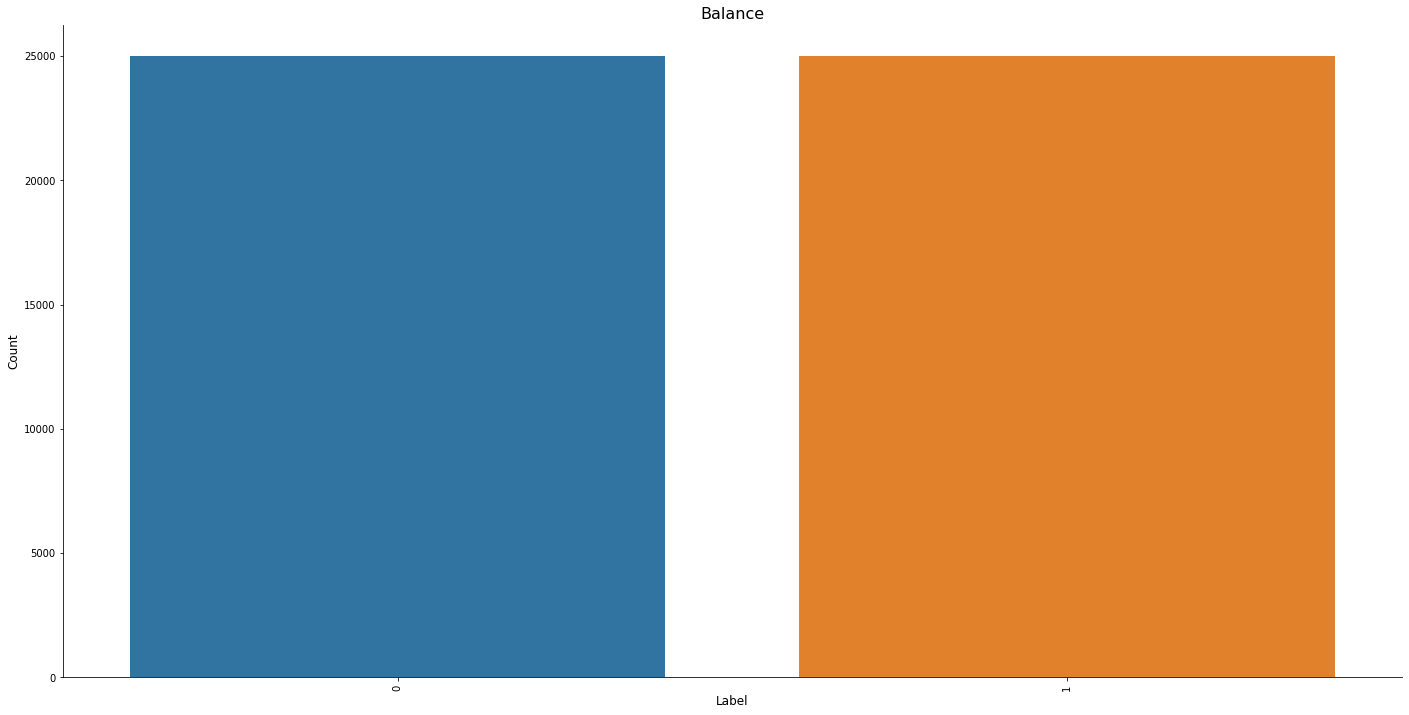

In [ ]:
plt.figure(figsize=(24,12))
plt.title('Balance', size=16)
sns.countplot(x=Y)
plt.ylabel('Count', size=12)
plt.xlabel('Label', size=12)
plt.xticks(rotation=90)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

# Tokenizando las reviews con el vocabulario del modelo de pos tag

In [ ]:

X_train_tk = word_tokenizer.texts_to_sequences(X_train)
X_test_tk = word_tokenizer.texts_to_sequences(X_test)

vocab_len = len(word_tokenizer.word_index) + 1 

In [ ]:
X_train_tk = pad_sequences(X_train_tk, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")
X_test_tk = pad_sequences(X_test_tk, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")

In [ ]:
X_train_tk.shape

(40000, 100)

In [ ]:
X_train_tk[1]

array([ 1464,   848,  2866,  1464,   848,  2866,   963,  1730,   362,
         875,  2131,   923,   938,  1730,   946,   676, 12676,   275,
       32623,  3355,  4093,  8675, 51990,  1083,  4093,  1181, 32623,
        3531,   328, 51990,   720,  6091,   566,  1151,  4771,  3695,
         480,  4412,  1097,  8456,    41,  1378,   152,  1243, 53734,
        9684, 45138, 18312,  1709, 49622,   184,   421, 18394,  8456,
         990,   300,   676,  1021,   185,   790,  1378,  4597,  9647,
        1505,    47,  2766,   240,  1517,   549,  1378,  1829, 19909,
       32819, 12528,  8614,  1156,  1513,  1221,  2984,  3557, 15485,
        1435,  1505,   608,  1221,  1981, 29760,  1079,   821,  4160,
        4610,  1181,  2365,  4771,  1151,  8456,  1292,  7252,  1221,
         169])

In [ ]:
embed_dim = 100

# Modelo sin pos tag
Se le entrega unicamente las reviews tokenizadas

In [ ]:
model = Sequential([
          layers.Embedding(input_dim=VOCABULARY_SIZE, 
                           output_dim=EMBEDDING_SIZE, 
                           input_length=MAX_SEQ_LENGTH),
          layers.Conv1D(128, 7, activation='relu'),
          layers.Conv1D(128,7, activation='relu'),
          layers.BatchNormalization(),
          layers.Dropout(0.25),
          layers.MaxPooling1D(pool_size=5, strides = 2),
          layers.Conv1D(64,5, activation='relu'),
          layers.Conv1D(64,5, activation='relu'),
          layers.BatchNormalization(),
          layers.Dropout(0.25),
          layers.Flatten(),
          layers.Dense(1, activation='sigmoid'),
    ])
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 100)          5944900   
                                                                 
 conv1d_8 (Conv1D)           (None, 94, 128)           89728     
                                                                 
 conv1d_9 (Conv1D)           (None, 88, 128)           114816    
                                                                 
 batch_normalization_4 (Batc  (None, 88, 128)          512       
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 88, 128)           0         
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 42, 128)          0         
 1D)                                                  

In [ ]:
model.fit(X_train_tk, y_train.values, epochs = 7, validation_data=(X_test_tk, y_test),batch_size=32)

Epoch 1/7
1250/1250 [==============================] - 35s 26ms/step - loss: 0.4538 - accuracy: 0.7844 - val_loss: 0.3357 - val_accuracy: 0.8557
Epoch 2/7
1250/1250 [==============================] - 31s 25ms/step - loss: 0.2541 - accuracy: 0.8985 - val_loss: 0.3701 - val_accuracy: 0.8471
Epoch 3/7
1250/1250 [==============================] - 31s 25ms/step - loss: 0.1563 - accuracy: 0.9401 - val_loss: 0.4227 - val_accuracy: 0.8501
Epoch 4/7
1250/1250 [==============================] - 31s 24ms/step - loss: 0.0854 - accuracy: 0.9686 - val_loss: 0.5358 - val_accuracy: 0.8463
Epoch 5/7
1250/1250 [==============================] - 31s 25ms/step - loss: 0.0589 - accuracy: 0.9790 - val_loss: 0.6036 - val_accuracy: 0.8450
Epoch 6/7
1250/1250 [==============================] - 32s 26ms/step - loss: 0.0418 - accuracy: 0.9854 - val_loss: 0.7269 - val_accuracy: 0.8427
Epoch 7/7
1250/1250 [==============================] - 32s 25ms/step - loss: 0.0357 - accuracy: 0.9869 - val_loss: 0.8003 - val_ac

# Pos tagging las reviews
Se hace un predict con el modelo para pos tag

In [ ]:
X_train_tagged=postag_model.predict(X_train_tk)

In [ ]:
X_test_tagged=postag_model.predict(X_test_tk)

In [ ]:
X_train_tk[0]

array([  694,  1664,   103, 11076,  6968,  7036, 20361,   195, 49437,
       40622, 14709,   634, 10135,   849,   226,  3557,   140,  2759,
        2326,  1572,   713,  3222,  3499,   866,   619,  4472,  5300,
        8371,   381,   111,   260, 13877,  1984, 17745,   119,  9326,
         424,    41, 27449,   791,  4077,  1278,   119,    39, 46136,
       15781,   312,  1028, 10240, 38451,  1916,  4157,  3025,  4373,
         171,  2263,   223,  7746,  2189,   474,  3926,  1361, 10772,
         809,  1021,  9079, 15688,  2722, 32510,   595,  3325,   416,
         169,   869,   274,   716,   206,    81,  4951,   364, 11877,
         152, 13404,   218, 22510,  7957,  9588,  5671,  2406,  5016,
       33473,   776, 31555,    92,  1239,   640,  5818,  1568,  2351,
        2471])

In [ ]:
def get_tag(data):
    decod_pred=[]
    for p in np.argmax(data,axis=2):
        aux=[]
        for i in p:
            if i !=0:
                aux.append(i)
            else:
                aux.append(12)
                #aux.append(tag_tokenizer.index_word[i])
        decod_pred.append(np.array(aux))
    return np.array(decod_pred)

In [ ]:
xtrain_decod=get_tag(X_train_tagged)
xtest_decod=get_tag(X_test_tagged)

In [ ]:
xtest_decod.shape

(10000, 100)

# Concatenando las reviews con sus respectivos pos tag

In [ ]:
x_train_final = np.hstack([X_train_tk,xtrain_decod])
x_test_final=np.hstack([X_test_tk,xtest_decod])

In [ ]:
x_test_final.shape

(10000, 200)

# Modelo para reviws + pos tag

In [ ]:
model2 = Sequential()
model2.add(Embedding(input_dim=vocab_len, output_dim=embed_dim, input_length=MAX_SEQ_LENGTH*2))
model2.add(Conv1D(128, 7, activation='relu'))
model2.add(Conv1D(128,7, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.25))
model2.add(MaxPooling1D(pool_size=5, strides = 2))
model2.add(Conv1D(64,5, activation='relu'))
model2.add(Conv1D(64,5, activation='relu'))
model2.add((BatchNormalization()))
model2.add(Dropout(0.25))
model2.add(Flatten())
model2.add(Dense(1, activation='sigmoid'))

model2.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 200, 100)          5944900   
                                                                 
 conv1d_12 (Conv1D)          (None, 194, 128)          89728     
                                                                 
 conv1d_13 (Conv1D)          (None, 188, 128)          114816    
                                                                 
 batch_normalization_6 (Batc  (None, 188, 128)         512       
 hNormalization)                                                 
                                                                 
 dropout_6 (Dropout)         (None, 188, 128)          0         
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 92, 128)          0         
 1D)                                                  

In [ ]:
model2.fit(x_train_final, y_train.values, epochs =7, validation_data=(x_test_final, y_test.values), batch_size=32)

Epoch 1/7
1250/1250 [==============================] - 42s 32ms/step - loss: 0.4379 - accuracy: 0.8023 - val_loss: 0.4084 - val_accuracy: 0.8042
Epoch 2/7
1250/1250 [==============================] - 42s 33ms/step - loss: 0.2377 - accuracy: 0.9064 - val_loss: 0.3327 - val_accuracy: 0.8665
Epoch 3/7
1250/1250 [==============================] - 41s 33ms/step - loss: 0.1377 - accuracy: 0.9473 - val_loss: 0.4196 - val_accuracy: 0.8628
Epoch 4/7
1250/1250 [==============================] - 40s 32ms/step - loss: 0.0685 - accuracy: 0.9748 - val_loss: 0.6753 - val_accuracy: 0.8399
Epoch 5/7
1250/1250 [==============================] - 40s 32ms/step - loss: 0.0417 - accuracy: 0.9855 - val_loss: 0.6831 - val_accuracy: 0.8596
Epoch 6/7
1250/1250 [==============================] - 41s 33ms/step - loss: 0.0314 - accuracy: 0.9890 - val_loss: 0.8380 - val_accuracy: 0.8528
Epoch 7/7
1250/1250 [==============================] - 41s 33ms/step - loss: 0.0271 - accuracy: 0.9908 - val_loss: 0.7489 - val_ac